# SAT Scores and Demographics: Uncovering Correlations in NYC High Schools

This project explores the relationships between demographics and SAT scores in New York City schools. Using data published by the city, we aimed to identify patterns and correlations between various factors such as school size, safety, demographics, and Advanced Placement exam participation, and their impact on SAT scores.

To achieve our goal, we analyzed the available data and used various statistical techniques to identify meaningful patterns and relationships. We also created visualizations to help us understand and communicate our findings effectively.

Our analysis revealed several interesting results. We found a positive correlation between overall school size and SAT scores, while smaller schools with "International" in their names tended to have lower SAT scores, possibly due to a focus on serving immigrant or international students. Additionally, there appears to be a positive correlation between perceived school safety and SAT scores, with schools in Manhattan, Bronx, and Queens being perceived as the safest.

Furthermore, we found a positive correlation between the percentage of white and Asian students in the school and SAT scores, and a negative correlation between the percentage of black and Hispanic students. We also identified schools that serve predominantly Hispanic student populations with low SAT scores, which have a focus on serving diverse student populations. On the other hand, we found specialized public high schools with very low percentages of Hispanic students and high SAT scores that require the Specialized High Schools Admissions Test (SHSAT) for admission.

Lastly, we discovered a positive correlation between the percentage of Advanced Placement exam takers in the school and its SAT score. These findings provide valuable insights into the factors that impact SAT scores in New York City schools.

### Importing libraries

In [164]:
import pandas as pd
import numpy as np
import re

### Read in the csv files

In [165]:
# Naming the data sets
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Creating dictionary to store dataframes
data = {}

# Storing csv files as dataframes in the dictionary
for file in data_files:
    name = re.search(r'(\w+).csv', file).group(1)
    data[name] = pd.read_csv('schools/'+file)

## Cleaning the Data

In [166]:
# Exploring the sat_results
data['sat_results'].head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on this output:
- The DBN appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores (SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score) into a single column to make the scores easier to analyze.

In [167]:
# Exploring all data sets
for key in data:
    print(data[key].head(5))

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

### Making the uniform DBN column

We can make some observations based on the first few rows of each one.
- Each dataset appears to either have a DBN column or the information we need to create one.
- Some fields look interesting for mapping - particularly Location 1, which contains coordinates inside a larger string.
- Some of the datasets appear to contain multiple rows for each school (because the rows have duplicate DBN values).

Class_size dataset doesn't appear to have the DBN column. However the DBN in the sat_results data is a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [168]:
# Renaming dbn column in hs_directory
data['hs_directory'].rename({'dbn':'DBN'}, axis=1, inplace=True)

# Adding 0 to CSD if CSD is less than 2 digits in class_size dataset
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(
    lambda x: '0'+str(x) if len(str(x)) < 2 else str(x))

# Creating DBN column in class_size as a combination of padded CSD and School Code
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Checking for DBN values
data['class_size']['DBN'].value_counts()

15K429    57
09X505    56
09X517    56
21K690    52
15K448    52
          ..
27Q273     3
03M452     3
09X090     2
27Q465     2
02M267     2
Name: DBN, Length: 1487, dtype: int64

### Combining the SAT scores

In [169]:
# Converting SAT scores columns to numeric
sat_columns = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

data['sat_results'][sat_columns] = data['sat_results'][sat_columns].apply(pd.to_numeric, errors='coerce')

# Aggregating SAT scores into one column
data['sat_results']['sat_score'] = data['sat_results'][sat_columns].sum(axis=1)

# Checking the results
data['sat_results']['sat_score'].head(5)

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

### Parsing Geographic Coordinates for Schools

Next, we'll parse the latitude and longitude coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory dataset.

In [170]:
# Creating functions to extract latitude and longitude from hs_directory dataset
def lat_finder(x):
    lat = re.findall('\(.+\)', x)[0].replace('(', '').replace(')', '').replace(',','').split()[0]
    return lat

def long_finder(x):
    long = re.findall('\(.+\)', x)[0].replace('(', '').replace(')', '').replace(',','').split()[1]
    return long

# Applying the functions
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(lat_finder)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(long_finder)

# Converting to numeric
data['hs_directory'][['lat', 'lon']] = data['hs_directory'][['lat', 'lon']].apply(pd.to_numeric, errors='coerce')

# Checking the new columns
data['hs_directory'][['lat', 'lon']].head(5)

,lat,lon
0,40.670299,-73.961648
1,40.827603,-73.904475
2,40.842414,-73.916162
3,40.710679,-74.000807
4,40.718810,-73.806500


### Read in the surveys

In [171]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Combining the surveys
survey = pd.concat([all_survey, d75_survey], axis=0)

In [172]:
# Exploring the survey
survey.head(5)

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- There are over 2000 columns, nearly all of which we don't need.
- The survey data also has a dbn column.

In [173]:
# Renaming the dbn column
survey.rename({"dbn":'DBN'}, axis=1, inplace=True)

# The columns we will need
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Extracting the columns
survey = survey.loc[:,survey_fields]

# Adding survey data into the dictionary
data["survey"] = survey

### Condensing datasets

The first thing we'll need to do in preparation for the merge is condense some of the datasets. The values in the DBN column are unique in the sat_results data set. Other data sets like class_size had duplicate DBN values.

We'll start with class_size dataset.

In [174]:
class_size = data['class_size']
class_size['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Since we're dealing with high schools, we're only concerned with grades 9 through 12.

In [175]:
class_size = class_size[class_size['GRADE '] == "09-12"]

In [176]:
class_size['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED'], dtype=object)

In [177]:
class_size['PROGRAM TYPE'].value_counts(dropna=False)

GEN ED     6513
CTT        2953
SPEC ED    1178
Name: PROGRAM TYPE, dtype: int64

Each school can have multiple program types. Since GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.

In [178]:
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head(5)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


Next we will group by DBN and calculate average across all columns

In [179]:
class_size = class_size.groupby('DBN').mean()
class_size.reset_index(inplace=True)
data['class_size'] = class_size
data['class_size'].head(5)

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1.0,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1.0,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1.0,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1.0,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1.0,57.6000,2.733333,21.200000,19.40,22.866667,NaN


Next we will condense demographics dataset

In [180]:
data['demographics'].head(5)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

In [181]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
data['demographics'].head(5)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


Next we will condense graduation dataset

In [182]:
data['graduation'].head(5)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [183]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']
data['graduation'].head(5)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


### Convert AP scores to numeric

The last thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college.

In [184]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
data['ap_2010'][cols] = data['ap_2010'][cols].apply(pd.to_numeric, errors='coerce')
data['ap_2010'][cols].dtypes

AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

## Combining the datasets

We'll be using the DBN column to identify matching rows across datasets.

There may be DBN values that exist in one dataset but not in another. This is partly because the data is from different years. Each data set also has inconsistencies in terms of how it was gathered.

Since this project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from sat_results while minimizing null values.

Some of the datasets have a lot of missing DBN values. This makes a left join more appropriate, because we don't want to lose too many rows when we merge.

In [185]:
# Combining with left join
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], how='left', on='DBN')
combined = combined.merge(data['graduation'], how='left', on='DBN')

combined.shape

(479, 33)

Some datasets have DBN values that are almost identical to those in sat_results. Those datasets also have information we need to keep. Therefore, we'll do an inner join to avoid missing data in these columns.

In [186]:
# Combining with inner join
combined = combined.merge(data['class_size'], on='DBN', how='inner')
combined = combined.merge(data['demographics'], on='DBN', how='inner')
combined = combined.merge(data['survey'], on='DBN', how='inner')
combined = combined.merge(data['hs_directory'], on='DBN', how='inner')

combined.shape

(363, 158)

We will fill in the missing values with the overall mean for the column.

In [187]:
# Filling na with column mean
means = combined.mean()
combined.fillna(means, inplace=True)

# Filling remaining na with 0 (if a columns consists entirely of na, the mean cannot be calucated)
combined.fillna(0, inplace=True)

# Checking
combined.isnull().sum().sum()

/var/folders/xw/3pj1fbx137g_tcv5h8ylvr2c0000gn/T/ipykernel_4618/1510400100.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = combined.mean()


0

## Finding correlations

We will find any correlations between columns and sat_score. This helps us determine which columns might be interesting to plot out or investigate further.

In [188]:
# Finding correlations with sat_score
correlations = combined.corr()['sat_score']
correlations

SAT Critical Reading Avg. Score    0.472399
SAT Math Avg. Score                0.465612
SAT Writing Avg. Score             0.472854
sat_score                          1.000000
AP Test Takers                     0.254925
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.080811
lon                               -0.048274
Name: sat_score, Length: 67, dtype: float64

In [189]:
# Filtering for correlation over 0.25
correlations[abs(correlations) > 0.25].sort_values(ascending=False)

sat_score                            1.000000
SAT Writing Avg. Score               0.472854
SAT Critical Reading Avg. Score      0.472399
SAT Math Avg. Score                  0.465612
SIZE OF LARGEST CLASS                0.378741
N_s                                  0.347000
N_p                                  0.334171
AVERAGE CLASS SIZE                   0.326426
total_enrollment                     0.308198
female_num                           0.306849
NUMBER OF STUDENTS / SEATS FILLED    0.305352
white_per                            0.302345
asian_num                            0.297773
NUMBER OF SECTIONS                   0.296805
N_t                                  0.294385
total_students                       0.291860
male_num                             0.289770
white_num                            0.279656
asian_per                            0.256366
AP Test Takers                       0.254925
Total Exams Taken                    0.250432
sped_percent                      

- SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score are strongly correlated with sat_score.
- Total_enrollment has a strong positive correlation with sat_score, implying larger schools tend to do better on the SAT. Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
- Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
- Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
- There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
- The percentage of students eligible for free or reduced school lunch based on household income (frl_percent) has a strong negative correlation with SAT scores.

### Exploring Enrollment and SAT scores

Since enrollment seems to have a strong correlation, we will make a scatterplot of total_enrollment vs sat_score, and add other school and class size indicators.

In [190]:
# Importing pyplot and enabling graphs in Jupyter Notebook
import matplotlib.pyplot as plt
%matplotlib inline

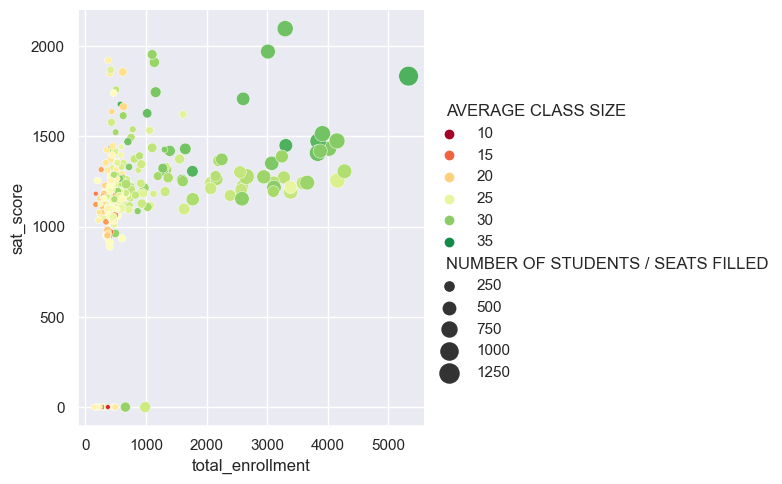

In [191]:
# Importing seaborn to display several features on one scatterplot
import seaborn as sns

# Setting Seaborn style for graphs
sns.set_theme()

sns.relplot(data=combined,
    y='sat_score', x='total_enrollment',
    hue='AVERAGE CLASS SIZE',
    size='NUMBER OF STUDENTS / SEATS FILLED',
    sizes=(10,200),
    palette='RdYlGn', # setting color palette Red-Yellow-Green
    )
plt.show()

There is a positive correlation between overall size of the school and its SAT scores.

There's also an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. It's worth exploring the names of the schools in this cluster.

In [192]:
# Filtering the combined dataframe to keep only those rows where total_enrollment is under 1000
# and sat_score is under 1000
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000)]
low_enrollment['SCHOOL NAME']

18                            MANHATTAN BUSINESS ACADEMY
19                             BUSINESS OF SPORTS SCHOOL
20            THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY
31                 MANHATTAN ACADEMY FOR ARTS & LANGUAGE
32           HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES
33             INTERNATIONAL HIGH SCHOOL AT UNION SQUARE
56           THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS
57                     THE GLOBAL LEARNING COLLABORATIVE
59                             FRANK MCCOURT HIGH SCHOOL
74     COLUMBIA SECONDARY SCHOOL FOR MATH, SCIENCE, A...
83             HIGH SCHOOL FOR EXCELLENCE AND INNOVATION
91                   INTERNATIONAL COMMUNITY HIGH SCHOOL
103          BRONX STUDIO SCHOOL FOR WRITERS AND ARTISTS
109    ANTONIA PANTOJA PREPARATORY ACADEMY, A COLLEGE...
111                            BRONX BRIDGES HIGH SCHOOL
123    BRONX EARLY COLLEGE ACADEMY FOR TEACHING & LEA...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                      BRONX 

Most schools have "International" in their names, suggesting that they may have a focus on serving immigrant or international students. Specifically, Kingsbridge International High School serves students who are new to the country and learning to speak English, while International Community High School in the South Bronx is described as facilitating an equitable environment for immigrants and the children of migrants. The other schools, Bronx International High School, International School for Liberal Arts, and High School of World Cultures, likely have similar missions of serving diverse student populations.

It might indicate that it's actually percentage of English learners (ell_percent) that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, we will add ell_percent to our plot.

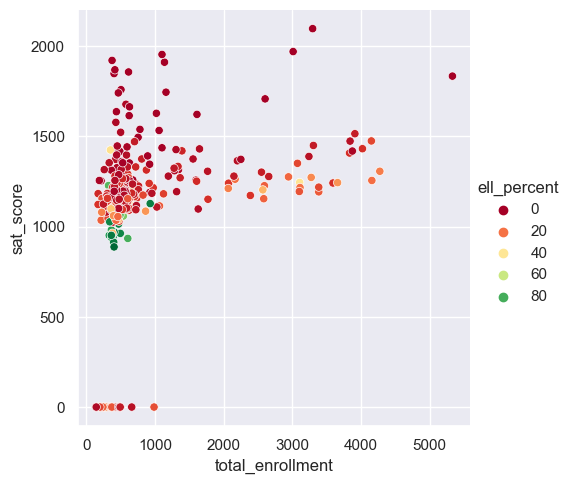

In [193]:
sns.relplot(data=combined,
    y='sat_score', x='total_enrollment',
    hue='ell_percent',
    palette='RdYlGn')
plt.show()

### Exploring Safety and SAT Scores

Next we will explore correlation of the school safety (saf_tot_11, saf_t_11, and saf_s_11) with sat_score.

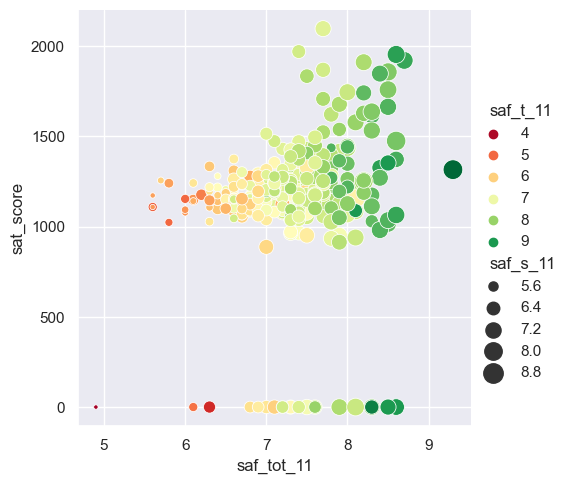

In [194]:
sns.relplot(data=combined,
    y='sat_score', x='saf_tot_11',
    hue='saf_t_11', # setting saf_t_11 as color intensity
    size='saf_s_11', # setting saf_s_11 as size
    sizes=(10,200),
    palette='RdYlGn')
plt.show()

There seems to be a positive correlation between the safety of the school as perceived by teachers and students and its SAT score.

We will aggregate the data by borough, which enables us to understand how school safety varies by geographic area.

In [195]:
# Aggregating by borough and computing means
boroughs = combined.groupby('boro').mean()
boroughs.reset_index(inplace=True)
boroughs

,boro,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,Bronx,384.050714,393.891831,379.655657,1078.666667,96.473842,149.445409,135.694086,136.857093,9.548387,...,12.0,12.0,10461.408602,549.569892,1.344086,0.0,0.0,0.0,40.845473,-73.890973
1,Brooklyn,391.336947,404.612644,385.414869,1112.113208,131.645682,202.857765,164.940094,183.870968,18.000000,...,12.0,12.0,11216.150943,751.556604,1.971698,0.0,0.0,0.0,40.665555,-73.947829
2,Manhattan,421.070149,437.824710,419.436551,1128.800000,126.135363,192.661966,153.337778,155.421505,2.900000,...,12.0,12.0,10024.744444,633.588889,1.433333,0.0,0.0,0.0,40.766244,-73.975350
3,Queens,422.274953,448.207556,416.270522,1191.171875,160.463942,238.014423,153.975000,307.208165,26.906250,...,12.0,12.0,11343.000000,1187.187500,2.390625,0.0,0.0,0.0,40.715715,-73.836422
4,Staten Island,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,31.000000,...,12.0,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726


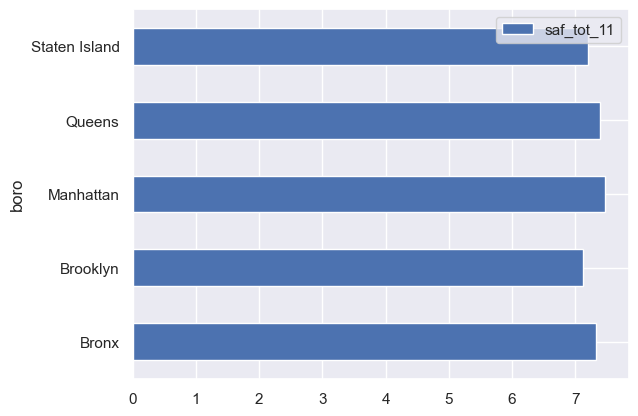

In [196]:
# Plotting school safety by borough
boroughs.plot.barh('boro', 'saf_tot_11')
plt.show()

Manhattan, Bronx, and Queens schools are perceived as the safest.

### Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

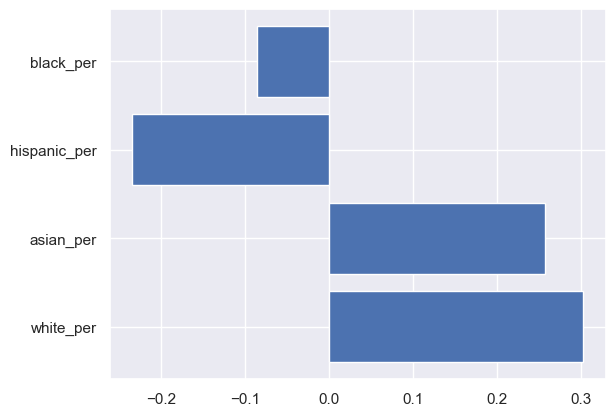

In [197]:
plt.barh(['white_per', 'asian_per', 'hispanic_per', 'black_per'],
         correlations[['white_per', 'asian_per', 'hispanic_per', 'black_per']]
         )
plt.show()

It appears there are positive correlation between the percentage of white and Asian students in the school, and negative between the percentage of black and Hispanic students.

We will look into schools with low SAT scores and high values for hispanic_per.

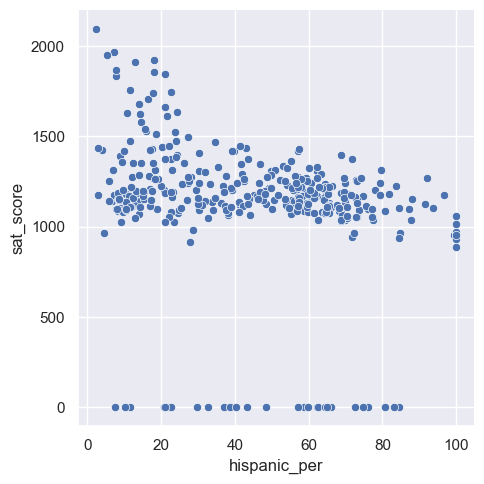

In [198]:
sns.relplot(data=combined,
    y='sat_score', x='hispanic_per')
plt.show()

There are schools with very high percentage of hispanic students (near 100%) that show low SAT scores (around 1000). We will look closer into those schools.

In [199]:
# Filtering the data
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

All of the schools listed here have a focus on serving diverse student populations. For example, Washington Heights Expeditionary Learning School is a public school that serves a predominantly low-income, Latino student population. Gregorio Luperon High School for Science and Mathematics is a public school that serves a predominantly Dominican student population. International School for Liberal Arts and Pan American International High School at Monroe both have "International" in their names, suggesting a focus on serving immigrant or international students. Manhattan Bridges High School, Academy for Language and Technology, Multicultural High School, and Pan American International High School are all public schools that serve diverse student populations in New York City.

Now we look into school with the least percentage of Hispanic students, and high SAT results.

In [200]:
# Filtering the data
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

All of the schools listed here are specialized public high schools in New York City that require students to take the Specialized High Schools Admissions Test (SHSAT) for admission. These schools are known for their rigorous academic programs and high-achieving student bodies. However, there has been ongoing debate about the lack of diversity in these schools, with few Black and Latino students being admitted. 

### Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:
- male_per
- female_per

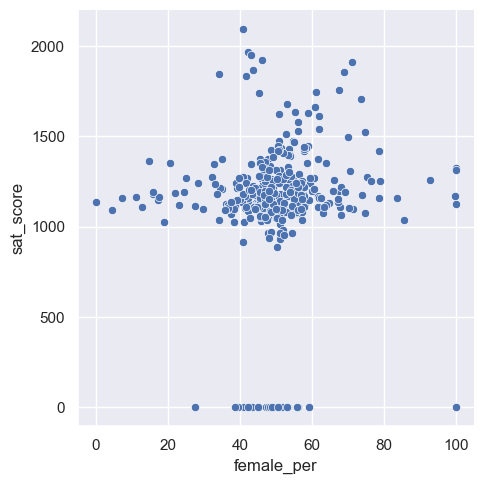

In [201]:
# Plotting the gender scatterplot
sns.relplot(data=combined,
    y='sat_score', x='female_per')
plt.show()

We will investigate schools with high SAT scores and a high female_per.

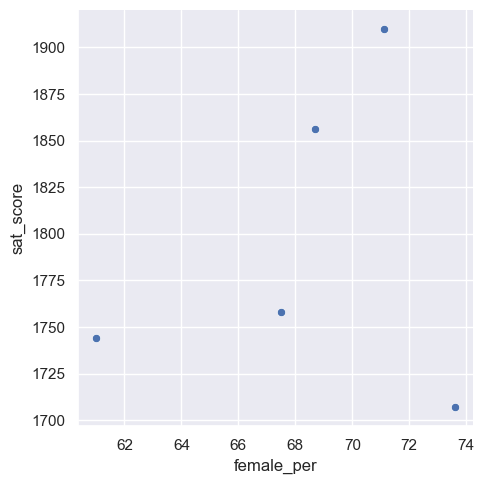

In [202]:
# Filtering schools with high female_per and SAT score
high_f_and_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

sns.relplot(data=high_f_and_sat,
    y='sat_score', x='female_per')
plt.show()

In [203]:
high_f_and_sat['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

All of the schools here are public high schools in New York City that are highly regarded for their academic programs and selective admissions processes. Bard High School Early College, Eleanor Roosevelt High School, Beacon High School, Fiorello H. LaGuardia High School of Music & Art and Performing Arts, and Townsend Harris High School are all ranked among the top public high schools in New York City. These schools offer rigorous academic programs and opportunities for students to earn college credit while still in high school.

### Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. We will explore this relationship.

Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

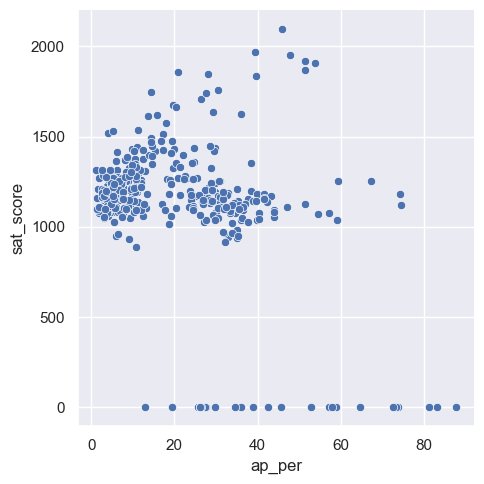

In [204]:
# Calculating the percentage of students in each school that took an AP exam
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100

# Plotting ap_per against sat scores
sns.relplot(data=combined,
    y='sat_score', x='ap_per')
plt.show()

There seems to be a positive correlation between percentage of AP takers and SAT score.

## Conclusion

In this project, our goal was to analyze the relationship between various factors and the SAT scores of New York City high schools. We took a data-driven approach and analyzed different variables such as school size, safety, diversity, and Advanced Placement exams to understand their impact on SAT scores.

Our study found a positive correlation between overall school size and SAT scores, as well as a correlation between perceived school safety and higher SAT scores. Additionally, schools with a high percentage of white and Asian students tend to have higher SAT scores, while those with a high percentage of black and Hispanic students tend to have lower scores. However, our study also identified exceptions to this trend, particularly for schools with a diverse student population that have a focus on serving their community, such as those serving predominantly Hispanic student populations. These schools may have lower SAT scores despite their efforts to support a diverse student body.

We also found that schools with a high percentage of students taking Advanced Placement exams tend to have higher SAT scores. Lastly, we identified specialized public high schools with low percentages of Hispanic students and high SAT scores that require the Specialized High Schools Admissions Test (SHSAT) for admission, but have been criticized for their lack of diversity.

Overall, our analysis provides valuable insights into the factors that impact SAT scores in New York City high schools. Our findings might suggest that policymakers and educators should pay attention to these factors to improve the educational outcomes of students.